In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy.stats import probplot
import math

In [2]:
DATA_DIR = 'data'
INPUT_DIR = 'input'
OUTPUT_DIR = 'output'
INPUT_PATH = f'{DATA_DIR}/{INPUT_DIR}'
OUTPUT_PATH = f'{DATA_DIR}/{OUTPUT_DIR}'

In [3]:
df = pd.read_csv(f'{INPUT_PATH}/sectoral_fundamentals.csv')
sector_column = 'gicdesc'
date_column = 'public_date'
df[date_column] = pd.to_datetime(df[date_column])
df = df.set_index([sector_column, date_column])

In [4]:
percent_cols = [col for col in df.columns if df[col].dtype == "object" and df[col].str.contains('%').any()]
for col in percent_cols:
    df[col] = df[col].str.rstrip('%').astype('float') / 100

In [5]:
source_df = df.copy()

In [6]:
source_df.index.names

FrozenList(['gicdesc', 'public_date'])

In [7]:
df = df.reset_index().loc[df.reset_index()['gicdesc'] == 'Energy'].set_index(source_df.index.names)

# Simulated Portafolio Approach

In [8]:
target_columns = ['simulated_portfolio_value']
returns_col = ['indret_ew']

# Define the initial portafolio value
initial_portafolio_value = 10000

# Convert MoM percentage change to multiplicative factors
df['multiplicative_factor'] = 1 + df[returns_col]
# Calculate the cumulative product of multiplicative factors
df['cumulative_factor'] = df['multiplicative_factor'].cumprod()

# Calculate the market capitalization using the cumulative factor
df[target_columns[0]] = initial_portafolio_value * df['cumulative_factor']
df[target_columns] = df[target_columns].shift(-1)
# df[target_columns] = df[target_columns].shift(1)

In [9]:
# Create holdout set
holdout_size = int(len(df) * 0.2)
holdout_df = df[-holdout_size:]
df = df[:-holdout_size]
test_size = int(len(df) * 0.2)
test_df = df[-test_size:]
df = df[:-test_size]

In [10]:
corr_all = df.corr()[target_columns]
corr_df = corr_all[target_columns].abs().sort_values(by=target_columns, ascending=False).drop(['simulated_portfolio_value','cumulative_factor'])

In [11]:
top_10_corr_features = corr_df.head(10).index.tolist()

In [12]:
# from prophet import Prophet

# # Get the top 10 most correlated features
# top_10_corr_features = corr_all['simulated_portfolio_value'].abs().sort_values(ascending=False).drop(['simulated_portfolio_value']).head(10).index.tolist()

# # Prepare the dataframe for Prophet
# df_prophet = df[top_10_corr_features + target_columns]
# df_prophet = df_prophet.reset_index().drop(columns=['gicdesc']).rename(columns={'public_date': 'ds', target_columns[0]: 'y'})

# # Initialize the Prophet model
# model = Prophet()

# # Fit the model
# model.fit(df_prophet)

# # Make future predictions
# # future = model.make_future_dataframe(periods=3)
# future = test_df.reset_index().drop(columns=['gicdesc']).rename(columns={'public_date': 'ds', target_columns[0]: 'y'})
# forecast = model.predict(future)

In [13]:
# # Plot the forecast
# model.plot(forecast)
# # Plot the actual values
# plt.plot(forecast['ds'], test_df[target_columns[0]], 'r.', label='Actual')

# # Add legend and show the plot
# plt.legend()
# plt.show()

# # Plot the components
# model.plot_components(forecast)
# plt.show()

In [14]:
# from sklearn.metrics import mean_squared_error
# from math import sqrt
# import matplotlib.pyplot as plt

# # Prepare the data for ARIMA
# df_arima = df_prophet.set_index('ds')['y']
# # Split the data into training and test sets
# train_df = df_arima[:-12]  # use all but the last 12 months for training
# test_df = df_arima[-12:]  # use the last 12 months for testing

# # Fit the model on the training data
# model = pm.auto_arima(train_df, seasonal=True, m=12)
# model.fit(train_df)

# # Make predictions on the test data
# forecast = model.predict(n_periods=len(test_df))

# # Calculate RMSE
# rmse = sqrt(mean_squared_error(test_df, forecast))
# print(f'RMSE: {rmse}')

# # Plot actual vs predicted values
# plt.figure(figsize=(10, 6))
# plt.plot(train_df.index, train_df, label='Train')
# plt.plot(test_df.index, test_df, label='Test')
# plt.plot(test_df.index, forecast, label='Predicted')
# plt.legend(loc='best')
# plt.title('Actual vs Predicted')
# plt.show()

/var/folders/1d/kv_hjxmx7nd1vchnnhkfclm00000gn/T/ipykernel_4382/3243853298.py:1: DeprecationWarning: 'cgi' is deprecated and slated for removal in Python 3.13
  from cgi import test


RMSE: 0.1487256271011412


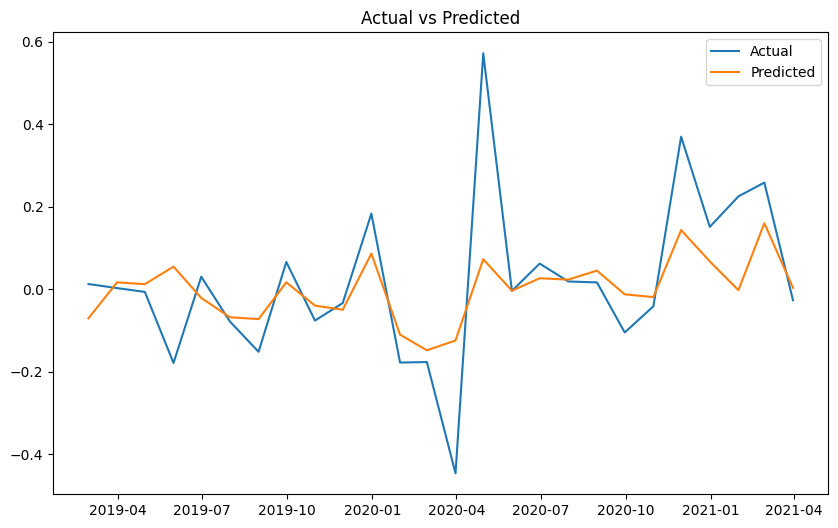

In [15]:
from cgi import test
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from math import sqrt
import matplotlib.pyplot as plt

# Prepare the data for Linear Regression
X_train = df[top_10_corr_features]
y_train = df[target_columns]
X_test = test_df[top_10_corr_features]
y_test = test_df[target_columns]

# Initialize the Linear Regression model
model = LinearRegression()

# Fit the model with the training data
model.fit(X_train, y_train)

# Make predictions on the test data
predictions = model.predict(X_test)

# Convert back to percentage change
actual_predictions = pd.Series(np.array(predictions).flatten()).pct_change()[1:]#.shift(-1)
actual_y_test = test_df[returns_col]
actual_y_test = np.array(actual_y_test.values).flatten()[1:]

# Calculate RMSE
rmse = sqrt(mean_squared_error(y_test, predictions))
rmse = sqrt(mean_squared_error(actual_y_test, actual_predictions))
print(f'RMSE: {rmse}')



# Plot actual vs predicted values
plt.figure(figsize=(10, 6))
# plt.plot([x[1] for x in y_test.index], y_test, label='Actual')
# plt.plot([x[1] for x in y_test.index], predictions, label='Predicted')

plt.plot([x[1] for x in y_test.index][1:], actual_y_test, label='Actual')
plt.plot([x[1] for x in y_test.index][1:], actual_predictions, label='Predicted')
plt.legend(loc='best')
plt.title('Actual vs Predicted')
plt.show()

In [43]:
from statsmodels.tsa.stattools import grangercausalitytests

# Define the maximum number of lags that you want to test
maxlag = 12

exclude_features = ['rd_sale_Median', 'adv_sale_Median', 'staff_sale_Median']
features_to_check = [x for x in corr_df.index.to_list() if x not in exclude_features]
# features_to_check = top_10_corr_features

granger_results = []
for feature in features_to_check:
    print(f'------- FEATURE: {feature} -------')
    best_lag = float('inf')
    best_p_value = float('inf')

    # Run the Granger causality test
    results = grangercausalitytests(df[[target_columns[0], feature]], maxlag)

    # The results are stored in a dictionary. You can access the results for each lag as follows:
    for i in range(maxlag, 0, -1):
        p_value = results[i][0]['ssr_ftest'][1]  # get the p-value of the F-test
        if p_value < best_p_value or (p_value == best_p_value and i < best_lag):
            best_p_value = p_value
            best_lag = i

    # Add the results to the DataFrame
    significant = best_p_value < 0.05  # change this to the significance level you want
    granger_results.append({'Feature': feature, 'Best Lag': best_lag, 'P-Value': best_p_value, 'Significant': significant})
    print(f'------- END OF FEATURE: {feature} -------')

granger_df = pd.DataFrame(granger_results)
# Display the results
granger_df.to_excel(f'{OUTPUT_PATH}/granger_causality.xlsx', index=False)

------- FEATURE: pe_op_dil_Median -------

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.2689  , p=0.1350  , df_denom=104, df_num=1
ssr based chi2 test:   chi2=2.3343  , p=0.1265  , df=1
likelihood ratio test: chi2=2.3092  , p=0.1286  , df=1
parameter F test:         F=2.2689  , p=0.1350  , df_denom=104, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=3.0765  , p=0.0505  , df_denom=101, df_num=2
ssr based chi2 test:   chi2=6.4575  , p=0.0396  , df=2
likelihood ratio test: chi2=6.2685  , p=0.0435  , df=2
parameter F test:         F=3.0765  , p=0.0505  , df_denom=101, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=4.2069  , p=0.0076  , df_denom=98, df_num=3
ssr based chi2 test:   chi2=13.5223 , p=0.0036  , df=3
likelihood ratio test: chi2=12.7198 , p=0.0053  , df=3
parameter F test:         F=4.2069  , p=0.0076  , df_denom=98, df_num=3

Granger Causality
number of lags (no zero) 4
ssr base

In [1]:
# sns.scatterplot(data=df, x=target_columns[0], y='CAPEI_Median')

In [2]:
# sns.scatterplot(data=df, x=target_columns[0], y='pe_exi_Median')

In [3]:
# sns.lineplot(data=df, x=date_column, y=target_columns[0])

In [4]:
# df['ps_Median_EMA'] = df['ps_Median'].ewm(span=12, adjust=False).mean()
# sns.lineplot(data=df, x=date_column, y='ps_Median_EMA')

In [5]:
# df.corr()

In [6]:
# corr_all = df.corr()['MCAP']
# corr_all['MCAP']#.abs()#.sort_values(by='MCAP', ascending=False)

In [7]:
# df['ptb_Median_6M'].corr(df['indret_ew'])

In [8]:
# import statsmodels.tsa.stattools as stats

# # Assuming df is your DataFrame and 'ptb_Median', 'target_columns' are the columns you want to find cross-correlation between
# d1 = df['ptb_Median']
# d2 = df[target_columns]

# # Compute cross-correlations
# xcov = stats.ccf(d1, d2)

# # Plot the cross-correlation values
# plt.figure(figsize=(10, 5))
# plt.plot(range(len(xcov)), xcov)
# plt.title('Cross-correlation plot')
# plt.xlabel('Lag')
# plt.ylabel('Cross-correlation')
# plt.show()

In [10]:
# import statsmodels.graphics.tsaplots as tsaplots

# # Assuming xcov is your cross-correlation values
# tsaplots.plot_acf(xcov)
# plt.title('Autocorrelation plot')
# plt.xlabel('Lag')
# plt.ylabel('Autocorrelation')
# plt.show()

In [11]:
# from sklearn.model_selection import train_test_split
# from sklearn.linear_model import LinearRegression

# def create_model(df, target_var, exclude_vars=[]):
#     # Split remaining data
#     X = df.drop(columns=[target_var] + exclude_vars)
#     X = X.replace([np.inf, -np.inf], np.nan)
#     X = X.fillna(X.mean())
#     y = df[target_var]
#     # Determine the split point
#     split_point = int(len(X) * 0.8)

#     # Split the data
#     X_train, X_test = X[:split_point], X[split_point:]
#     y_train, y_test = y[:split_point], y[split_point:]

#     # Create and fit model
#     model = LinearRegression()
#     model.fit(X_train, y_train)

#     return model, X_train, X_test, y_train, y_test, holdout

# model, X_train, X_test, y_train, y_test, holdout = create_model(df, target_columns[0], exclude_vars=['cumulative_factor', 'multiplicative_factor'])

In [12]:
# actual_y_test = pd.Series(df.loc[y_test.index]['indret_ew'].reset_index(drop=True))

In [13]:
# predictions = model.predict(X_test)
# predictions_series = pd.Series(predictions)

# percentage_change = predictions_series.pct_change()

In [14]:
# residuals = actual_y_test - percentage_change
# SS_res = (residuals**2).sum()
# SS_tot = ((actual_y_test - actual_y_test.mean())**2).sum()
# r2_score = 1 - (SS_res / SS_tot)
# r2_score

In [15]:
# pd.DataFrame([percentage_change, actual_y_test]).T

In [16]:
# plt.plot(actual_y_test, label='True')
# plt.plot(percentage_change, label='Predicted')
# plt.legend()


In [17]:
# plt.plot(y_train.values, label='True')
# # plt.plot(X_train.values, label='Predicted')
# plt.legend()


In [18]:
# feature_names = X_train.columns
# coef_df = pd.DataFrame({'feature': feature_names, 'coefficient': model.coef_})

# sns.barplot(data=coef_df, x='coefficient', y='feature')

In [19]:
# X_test

In [78]:
from sklearn.metrics import mean_squared_error

mean_squared_error(y_test, model.predict(X_test))


267452.5040549259

# Percentage based approach


In [27]:
# lagged_2mo_col = returns_col + '_2mo'
# df[lagged_2mo_col] = df[returns_col].shift(8)

In [20]:
# df['ptb_change'] = df['ptb_Median'].pct_change()
# df['dpr_change'] = df['dpr_Median'].pct_change()
# df['ptb_cumprod'] = (1 + df['ptb_change']).cumprod()
# df.corr()[lagged_2mo_col].drop(lagged_2mo_col).abs().sort_values(ascending=False)

In [21]:
# corr_all = df.corr()[target_columns].drop(target_columns + ['cumulative_factor', 'multiplicative_factor'], errors='ignore')
# corr_all[target_columns].abs().sort_values(by=target_columns, ascending=False).head(20)